In [4]:
import torch
from torch import tensor
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from fuzzywuzzy import fuzz
from gensim import corpora
from gensim.summarization.bm25 import BM25
import sys
sys.path.insert(1, '../')
from repobench.metrics import accuracy_at_k

/data/home/dimitriishh/workspace/envs/base_env/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [7]:
import json
with open('../repobench/data/easy_fixed.jsonl', 'r') as json_file:
    raw_data = list(json_file)
len(raw_data)

12000

In [8]:
data = [json.loads(row) for row in raw_data]

In [9]:
gold_snippets = [data[i]['gold_snippet_index'] for i in range(len(data))]

In [7]:
snippets_col = 'context'
query_col = 'next_line'

In [10]:
embedder = SentenceTransformer('all-MiniLM-L12-v2')
cos_scores = []
sorted_snippets = []
for i in tqdm(range(len(data))):
    # Corpus with example sentences
    corpus_embeddings = embedder.encode(data[i][snippets_col], convert_to_tensor=True)
    # Query sentences:
    query_embedding = embedder.encode(data[i][query_col], convert_to_tensor=True)
    cur_scores = util.cos_sim(query_embedding, corpus_embeddings)[0].cpu()
    cos_scores.append(cur_scores)
    sorted_snippets.append(torch.argsort(cur_scores, descending=True))
pd.DataFrame({
    'cos_scores': cos_scores,
    'sorted_snippets': sorted_snippets
}).to_csv('data/all_miniLM-L12-not_cropped_easy.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 12000/12000 [19:01<00:00, 10.51it/s]


In [14]:
embedder = SentenceTransformer('all-distilroberta-v1')
cos_scores = []
sorted_snippets = []
for i in tqdm(range(len(data))):
    # Corpus with example sentences
    corpus_embeddings = embedder.encode(data[i][snippets_col], convert_to_tensor=True)
    # Query sentences:
    query_embedding = embedder.encode(data[i][query_col], convert_to_tensor=True)
    cur_scores = util.cos_sim(query_embedding, corpus_embeddings)[0].cpu()
    cos_scores.append(cur_scores)
    sorted_snippets.append(torch.argsort(cur_scores, descending=True))
pd.DataFrame({
    'cos_scores': cos_scores,
    'sorted_snippets': sorted_snippets
}).to_csv('data/all-distilroberta-not_cropped_easy.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 12000/12000 [49:57<00:00,  4.00it/s]


In [15]:
embedder = SentenceTransformer('intfloat/e5-large-v2')
cos_scores = []
sorted_snippets = []
for i in tqdm(range(len(data))):
    # Corpus with example sentences
    corpus_embeddings = embedder.encode(data[i][snippets_col], convert_to_tensor=True)
    # Query sentences:
    query_embedding = embedder.encode(data[i][query_col], convert_to_tensor=True)
    cur_scores = util.cos_sim(query_embedding, corpus_embeddings)[0].cpu()
    cos_scores.append(cur_scores)
    sorted_snippets.append(torch.argsort(cur_scores, descending=True))
pd.DataFrame({
    'cos_scores': cos_scores,
    'sorted_snippets': sorted_snippets
}).to_csv('data/e5-large-v2-not_cropped_easy.csv')

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [3:51:50<00:00,  1.16s/it]


In [2]:
def crop_report(filename):
    df_mini = pd.read_csv('data/' + filename)
    df_mini['gold'] = gold_snippets
    df_mini['sorted_snippets'] = df_mini['sorted_snippets'].apply(lambda x: eval(x))
    df_mini['cos_scores'] = df_mini['cos_scores'].apply(lambda x: eval(x))
    pos_scores = []
    neg_scores = []
    for i in range(len(df_mini)):
        if df_mini['sorted_snippets'][i][0] == df_mini['gold'][i]:
            pos_scores.append(max(df_mini.iloc[i, 1]))
        else:
            neg_scores.append(max(df_mini.iloc[i, 1]))
    avg_pos = sum(pos_scores)/len(pos_scores)
    avg_neg = sum(neg_scores)/len(neg_scores)
    plt.hist(pos_scores, alpha=0.5, label='Positive')
    plt.hist(neg_scores, alpha=0.5, label='Negative')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title(filename)
    plt.legend()
    plt.show()
    print(f'''{filename}
Accuracy: {len(pos_scores)/len(df_mini):.3f}
Average top snippet score for positive cases: {avg_pos:.3f}
Average top snippet score for negative cases: {avg_neg:.3f}''')

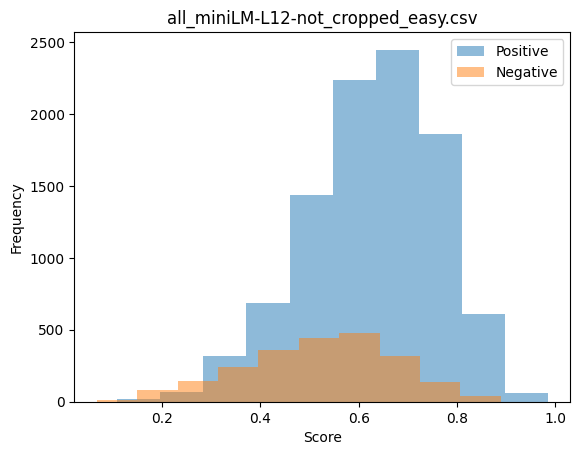

all_miniLM-L12-not_cropped_easy.csv
Accuracy: 0.812
Average top snippet score for positive cases: 0.627
Average top snippet score for negative cases: 0.519


In [17]:
crop_report('all_miniLM-L12-not_cropped_easy.csv')

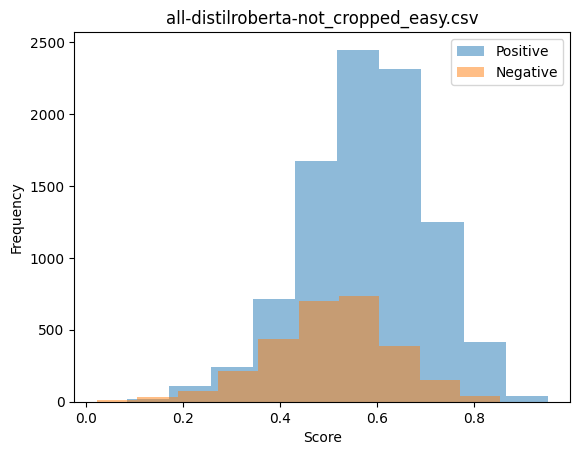

all-distilroberta-not_cropped_easy.csv
Accuracy: 0.768
Average top snippet score for positive cases: 0.580
Average top snippet score for negative cases: 0.505


In [18]:
crop_report('all-distilroberta-not_cropped_easy.csv')

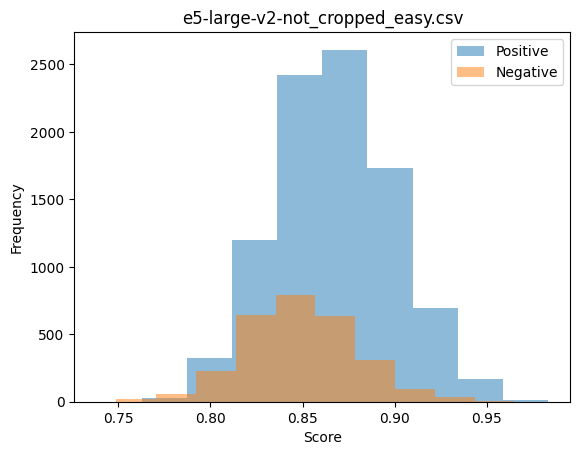

e5-large-v2-not_cropped_easy.csv
Accuracy: 0.766
Average top snippet score for positive cases: 0.867
Average top snippet score for negative cases: 0.849


In [19]:
crop_report('e5-large-v2-not_cropped_easy.csv')

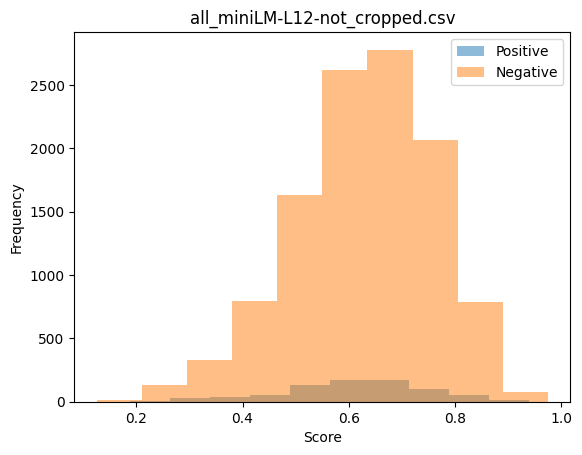

all_miniLM-L12-not_cropped.csv
Accuracy: 0.065
Average top snippet score for positive cases: 0.609
Average top snippet score for negative cases: 0.628


In [10]:
crop_report('all_miniLM-L12-not_cropped.csv')

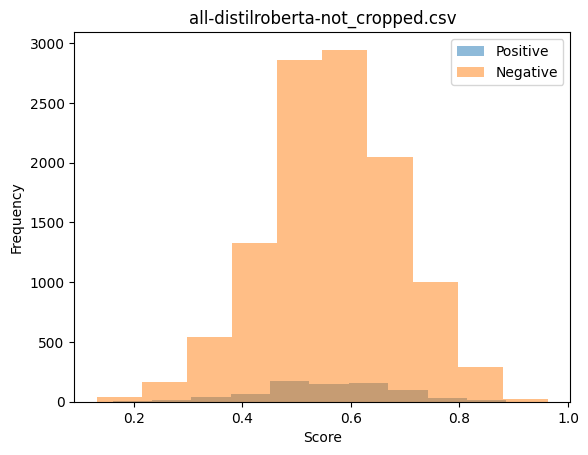

all-distilroberta-not_cropped.csv
Accuracy: 0.063
Average top snippet score for positive cases: 0.558
Average top snippet score for negative cases: 0.566


In [11]:
crop_report('all-distilroberta-not_cropped.csv')